
# Week 3: Training with Optimizers, Loss Visualization, and Regularization

This notebook demonstrates:
- Training a simple neural network with different optimizers (SGD, SGD+Momentum, Adam)
- Visualizing **loss** and **accuracy** over epochs
- Applying **regularization** techniques: weight decay (L2) and dropout


In [ ]:

import torch #Imports the main PyTorch library.
import torch.nn as nn #Imports the neural network module from PyTorch.
import torch.optim as optim #Used to update model weights during training.
import torchvision #A PyTorch package for computer vision tasks.
import torchvision.transforms as transforms #Used to transform images before feeding into model.
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #“Is GPU available?”
print("Using device:", device)

#cuda: CUDA = A programming platform that allows your code to run on NVIDIA GPUs. CUDA is a software platform created by: NVDIA


Using device: cpu


Key Details of Fashion-MNIST:
-- Structure: 60,000 training and 10,000 test images (70,000 total).
-- Dimensions: 28 * 28  pixels (grayscale).
-- Classes: 10 categories (T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot).

In [ ]:

# Use FashionMNIST for speed and interpretability
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
'''
To tensor
0 → 0.0
255 → 1.0
normalize, mean = 0.5, std = 0.5
'''
'''Dataset = just storage
DataLoader = gives data in batches'''
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

classes = trainset.classes
print("Classes:", classes)


Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


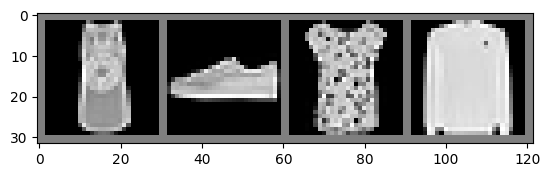

T-shirt/top Sneaker Shirt Pullover


In [ ]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5 #to 0 to 1
    npimg = img.numpy() #Converts PyTorch tensor → NumPy array.
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #(Channel, Height, Width) for tensor, matplotlib expects (Height, Width, Channel) np.transpose(npimg, (1, 2, 0))
    plt.show()


# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))
# Print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [ ]:

class MLP(nn.Module):
    def __init__(self, dropout_p=0.0):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:

def train_model(model, optimizer, epochs=10, weight_decay=0.0):
    criterion = nn.CrossEntropyLoss()
    train_losses, test_losses, train_accs, test_accs = [], [], [], []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Evaluation
        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        test_loss = test_loss / len(test_loader.dataset)
        test_acc = correct / total

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.3f}, Test Acc={test_acc:.3f}")

    return train_losses, test_losses, train_accs, test_accs


In [ ]:

def run_experiment(optimizer_name="SGD", lr=0.1, momentum=0.0, weight_decay=0.0, dropout_p=0.0, epochs=10):
    print(f"\nRunning {optimizer_name} (lr={lr}, momentum={momentum}, wd={weight_decay}, dropout={dropout_p})")
    model = MLP(dropout_p=dropout_p).to(device)
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Unknown optimizer")
    return train_model(model, optimizer, epochs=epochs)


In [ ]:

def plot_curves(train_losses, test_losses, train_accs, test_accs, title="Training Curves"):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, test_accs, label="Test Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend()

    plt.suptitle(title)
    plt.show()



Running SGD (lr=0.1, momentum=0.0, wd=0.0, dropout=0.0)
Epoch 1: Train Acc=0.208, Test Acc=0.100
Epoch 2: Train Acc=0.100, Test Acc=0.100
Epoch 3: Train Acc=0.101, Test Acc=0.100
Epoch 4: Train Acc=0.101, Test Acc=0.100
Epoch 5: Train Acc=0.100, Test Acc=0.100


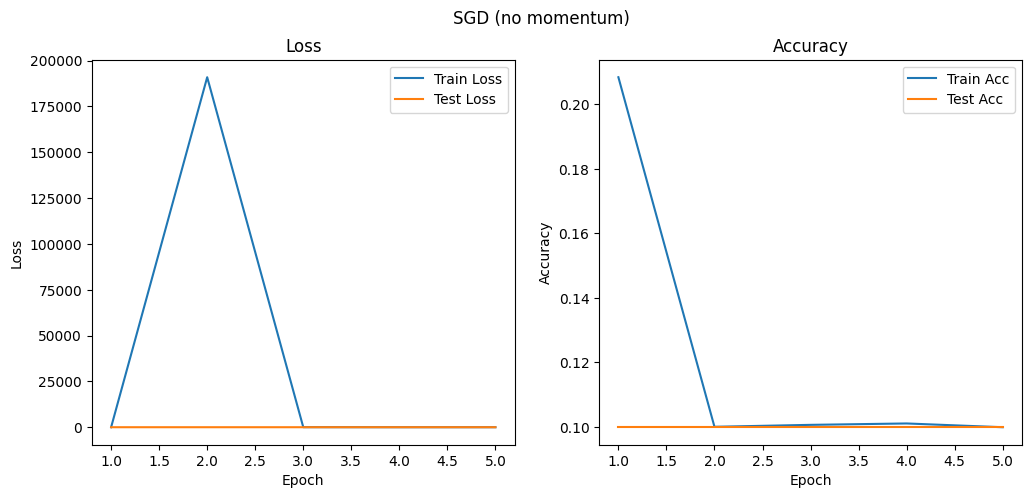


Running SGD (lr=0.1, momentum=0.9, wd=0.0, dropout=0.0)
Epoch 1: Train Acc=0.106, Test Acc=0.100
Epoch 2: Train Acc=0.100, Test Acc=0.100
Epoch 3: Train Acc=0.100, Test Acc=0.100
Epoch 4: Train Acc=0.100, Test Acc=0.100
Epoch 5: Train Acc=0.100, Test Acc=0.100


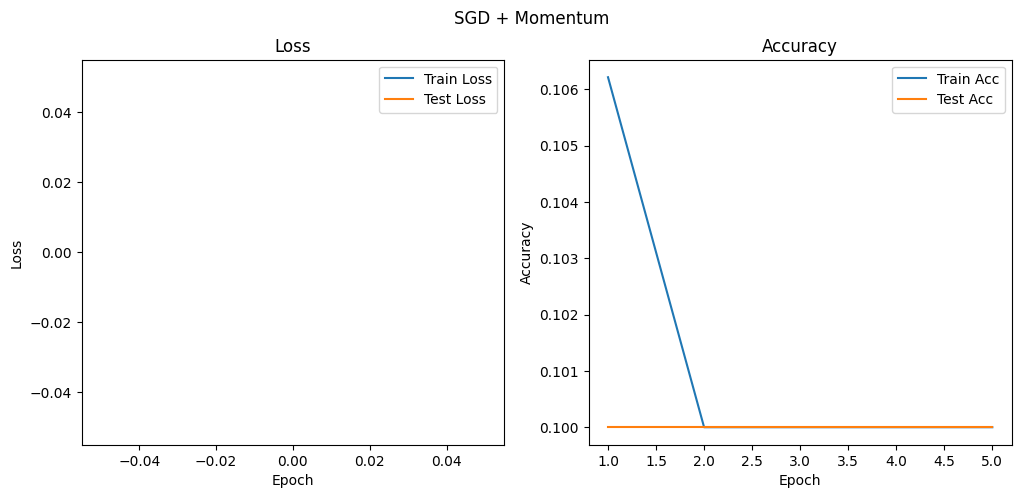


Running Adam (lr=0.001, momentum=0.0, wd=0.0, dropout=0.0)
Epoch 1: Train Acc=0.364, Test Acc=0.107
Epoch 2: Train Acc=0.114, Test Acc=0.100
Epoch 3: Train Acc=0.101, Test Acc=0.100
Epoch 4: Train Acc=0.099, Test Acc=0.100
Epoch 5: Train Acc=0.102, Test Acc=0.100


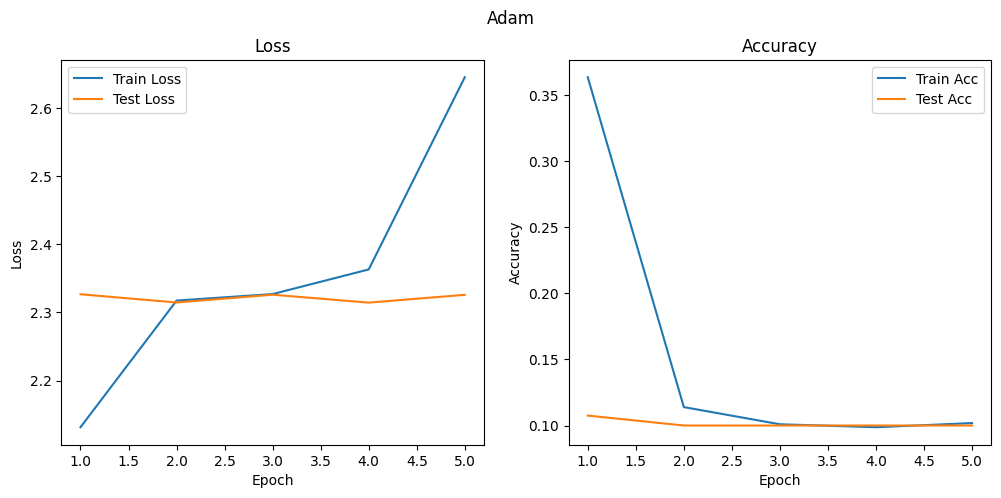


Running Adam (lr=0.001, momentum=0.0, wd=0.0001, dropout=0.0)
Epoch 1: Train Acc=0.387, Test Acc=0.202
Epoch 2: Train Acc=0.162, Test Acc=0.138
Epoch 3: Train Acc=0.143, Test Acc=0.144
Epoch 4: Train Acc=0.120, Test Acc=0.113
Epoch 5: Train Acc=0.127, Test Acc=0.128


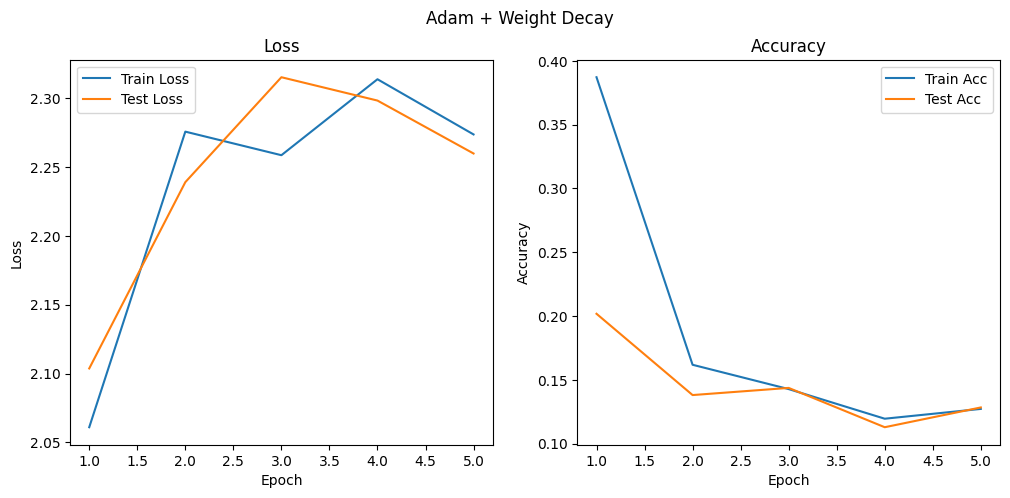


Running Adam (lr=0.001, momentum=0.0, wd=0.0, dropout=0.5)
Epoch 1: Train Acc=0.264, Test Acc=0.130
Epoch 2: Train Acc=0.111, Test Acc=0.100
Epoch 3: Train Acc=0.101, Test Acc=0.100
Epoch 4: Train Acc=0.100, Test Acc=0.100
Epoch 5: Train Acc=0.098, Test Acc=0.100


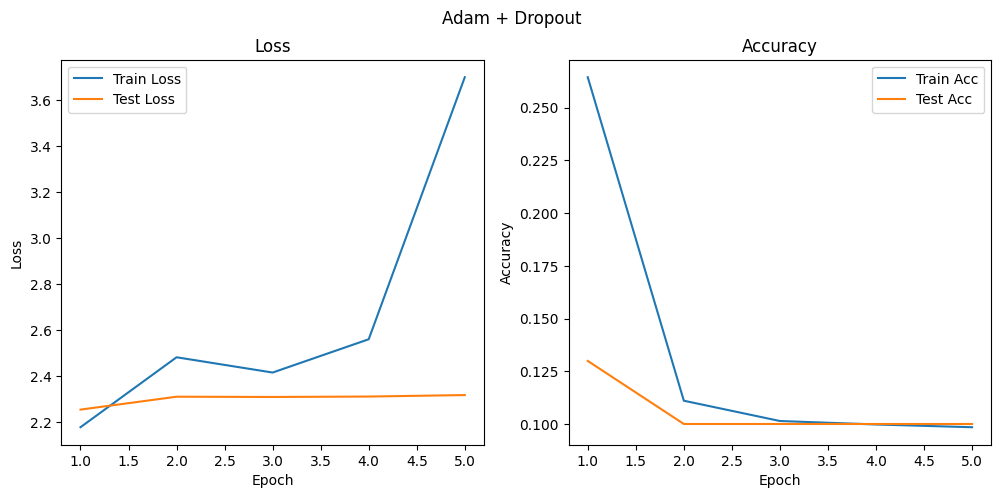

In [ ]:

# Run baseline SGD
sgd_results = run_experiment("SGD", lr=0.1, momentum=0.0, epochs=5)
plot_curves(*sgd_results, title="SGD (no momentum)")

# Run SGD + momentum
sgd_m_results = run_experiment("SGD", lr=0.1, momentum=0.9, epochs=5)
plot_curves(*sgd_m_results, title="SGD + Momentum")

# Run Adam
adam_results = run_experiment("Adam", lr=1e-3, epochs=5)
plot_curves(*adam_results, title="Adam")

# Adam + weight decay
adam_wd_results = run_experiment("Adam", lr=1e-3, weight_decay=1e-4, epochs=5)
plot_curves(*adam_wd_results, title="Adam + Weight Decay")

# Adam + dropout
adam_do_results = run_experiment("Adam", lr=1e-3, dropout_p=0.5, epochs=5)
plot_curves(*adam_do_results, title="Adam + Dropout")
